In [1]:
from pandas import DataFrame, read_csv, concat
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, GRU,ConvLSTM2D, Flatten
from matplotlib import pyplot as plt
from numpy import concatenate, reshape, array, hstack
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sys import argv
import csv
import datetime
import time
import pickle
from keras.models import model_from_json

In [2]:
dataset = read_csv('final_datasets/BTC.csv', parse_dates=['time']) 
savedDataset = dataset

startIndex = 3  #start from 3rd column
nrows = dataset.shape[0]
values = dataset.iloc[:,startIndex:].values #Getting values - Total Sentiment and BTC Values
valuesCrypto = dataset.iloc[:,-1:].values #Getting values -  C Values
# For predicting with just Cryptocurrency values, we have just 1 input variable. 
# Incorporating sentiment values will make input variables=2

# Comment the below line if there are multiple features / input variable.
# values = values.reshape(-1,1) #Only do this if you have 1 input variable
num =dataset.loc[dataset['time'] == '2020-12-01'].index[0]


In [3]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
#     print(sequences)
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern        
        end_ix = i + n_steps_in
#         print(i, end_ix)
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
#         print(seq_x)
        X.append(seq_x)        
        y.append(seq_y)
    return array(X), array(y)

In [4]:
def createData(sample, label):
    # First Column 
    in_seq1 = array(sample[:, 0])
    # Second Column
    in_seq2 = array(sample[:, 1])
    # Third Column 
    in_seq3 = array(sample[:, 2])
    # Label 
    out_seq = array(label[:])

    # convert to [rows, columns] structure
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    in_seq3 = in_seq3.reshape((len(in_seq3), 1))
    out_seq = out_seq.reshape((len(out_seq), 1))

    # horizontally stack columns
    dataset = hstack((in_seq1, in_seq2, in_seq3, out_seq))
    return dataset

In [5]:
def change_shape(sample):
    # flatten input    
    sample = sample.reshape((sample.shape[0], sample.shape[1] * sample.shape[2]))

    # For LSTM Shape
    sample = sample.reshape((sample.shape[0], 1, sample.shape[1]))
    return sample
    
    

In [6]:
num2= dataset.iloc[[-1]].index[0]
percent=num/num2
percent

# Scaling
scaler = MinMaxScaler(feature_range = (0,1))
scaler = scaler.fit(values)
scaled = scaler.fit_transform(values)

#Splitting data into train and test sets
n_train_days = int(percent*nrows) #90% data is train, 10% test
train = scaled[:n_train_days, :]
# train = train.values
test = scaled[n_train_days:nrows, :]
# test = test.values
# valuesCrypto = reframed.iloc[:,-1:].values #Getting values -  C Values

In [7]:
#Assigning inputs and output datasets
train_X, train_y = train[:-1, :], train[1:, -1]
test_X, test_y = test[:-1, :], test[1:, -1]

In [8]:
# #Reshaping input to be 3 dimensions (samples, timesteps, features)
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

trainingDataset = createData(train_X, train_y)
testingDataset = createData(test_X, test_y)

In [9]:
# choose a number of time steps
n_steps_in, n_steps_out = 1, 2

In [10]:
# convert training data into input/output
trainX, trainy = split_sequences(trainingDataset, n_steps_in, n_steps_out)
n_input = trainX.shape[1] * trainX.shape[2]
trainX= change_shape(trainX)

In [11]:
# convert testing data into input/output
testX, testy = split_sequences(testingDataset, n_steps_in, n_steps_out)
testX= change_shape(testX)

In [49]:

# model = Sequential()
# model.add(Bidirectional(GRU(50, activation='relu', input_dim=n_input)))
# model.add(LSTM(50,activation ='tanh'))
# model.add(Dropout(0.3))
# model.add(Dense(n_steps_out))
# model.compile(optimizer='adam', loss='mse',metrics=['acc'])

# # define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(n_steps_out, activation='relu'))
model.compile(optimizer='adam', loss='mse')
# fit model
# model.fit(X, y, epochs=100, verbose=2)
model.fit(trainX, trainy, epochs = 100, batch_size=64, validation_data=(testX, testy), verbose=2, shuffle=False) #Best so far: 100 neurons, epochs = 400, batch_size = 53

# demonstrate prediction

Epoch 1/100
88/88 - 1s - loss: 0.0022 - val_loss: 0.3013
Epoch 2/100
88/88 - 0s - loss: 0.0033 - val_loss: 0.3078
Epoch 3/100
88/88 - 0s - loss: 0.0028 - val_loss: 0.2918
Epoch 4/100
88/88 - 0s - loss: 0.0026 - val_loss: 0.2658
Epoch 5/100
88/88 - 0s - loss: 0.0024 - val_loss: 0.2263
Epoch 6/100
88/88 - 0s - loss: 0.0022 - val_loss: 0.1698
Epoch 7/100
88/88 - 0s - loss: 0.0018 - val_loss: 0.0959
Epoch 8/100
88/88 - 0s - loss: 0.0014 - val_loss: 0.0248
Epoch 9/100
88/88 - 0s - loss: 8.5366e-04 - val_loss: 0.0045
Epoch 10/100
88/88 - 0s - loss: 5.4331e-04 - val_loss: 0.0218
Epoch 11/100
88/88 - 0s - loss: 3.7515e-04 - val_loss: 0.0279
Epoch 12/100
88/88 - 0s - loss: 3.2826e-04 - val_loss: 0.0316
Epoch 13/100
88/88 - 0s - loss: 2.9848e-04 - val_loss: 0.0362
Epoch 14/100
88/88 - 0s - loss: 2.6219e-04 - val_loss: 0.0392
Epoch 15/100
88/88 - 0s - loss: 2.7086e-04 - val_loss: 0.0362
Epoch 16/100
88/88 - 0s - loss: 2.6004e-04 - val_loss: 0.0323
Epoch 17/100
88/88 - 0s - loss: 2.5843e-04 - val_

In [50]:
model_prediction = model.predict(testX)

In [51]:
model_prediction

array([[0.25753573, 0.2579391 ],
       [0.25556037, 0.255922  ],
       [0.25367782, 0.25408027],
       ...,
       [0.5476555 , 0.55298835],
       [0.5330981 , 0.5383107 ],
       [0.5430833 , 0.5482484 ]], dtype=float32)

In [52]:
# Inverse Scale
scalerCrypto = MinMaxScaler(feature_range = (0,1))
scalerCrypto = scaler.fit(valuesCrypto)
scaledCrypto = scaler.fit_transform(valuesCrypto)


model_prediction_unscale = scalerCrypto.inverse_transform(model_prediction.squeeze())
# predictedValues = reshape(model_prediction_unscale, model_prediction_unscale.shape[0]*model_prediction_unscale.shape[1])

actualValues = valuesCrypto[n_train_days+n_steps_in:] #test_y+input_sequence:


actualValues = reshape(actualValues, actualValues.shape[0])


In [53]:
model_prediction_unscale

array([[19067.217, 19091.822],
       [18946.725, 18968.783],
       [18831.893, 18856.441],
       ...,
       [36763.926, 37089.22 ],
       [35875.953, 36193.914],
       [36485.03 , 36800.094]], dtype=float32)

In [54]:
model_prediction_unscale
model_prediction_unscaleDF = DataFrame(model_prediction_unscale, columns = ['Predicted (t+1)','Predicted (t+2)'])
actualDF1 = DataFrame(actualValues, columns=['Actual (t+1)'])
actualDF2 = DataFrame(actualValues[1:], columns=['Actual (t+2)'])
timestamp = DataFrame(savedDataset['time'][n_train_days+1:], columns= ['time'])
timestamp.reset_index(drop=True, inplace=True)
results=concat([timestamp,model_prediction_unscaleDF, actualDF1, actualDF2], axis=1)
print("Head: ",results.head())
print("Tail: ",results.tail())
results.dropna(inplace=True)
results.to_csv('Double BTC.csv', index= False)


Head:                   time  Predicted (t+1)  Predicted (t+2)  Actual (t+1)  \
0 2020-12-01 03:00:00     19067.216797     19091.822266  19494.603333   
1 2020-12-01 06:00:00     18946.724609     18968.783203  19454.703333   
2 2020-12-01 09:00:00     18831.892578     18856.441406  19604.606667   
3 2020-12-01 12:00:00     19113.441406     19135.316406  18938.323333   
4 2020-12-01 15:00:00     18464.712891     18485.488281  19216.383333   

   Actual (t+2)  
0  19454.703333  
1  19604.606667  
2  18938.323333  
3  19216.383333  
4  18965.876667  
Tail:                      time  Predicted (t+1)  Predicted (t+2)  Actual (t+1)  \
1457 2021-06-01 06:00:00     36481.417969     36805.089844  37018.516667   
1458 2021-06-01 09:00:00     36763.925781     37089.218750  36304.003333   
1459 2021-06-01 12:00:00     35875.953125     36193.914062  36592.830000   
1460 2021-06-01 15:00:00     36485.031250     36800.093750  36265.610000   
1461 2021-06-01 18:00:00              NaN              NaN 

In [55]:
with open('Double BTC.csv', newline='') as read_file:

    results = csv.reader(read_file, delimiter=',', quotechar='|')
    next(results)

    time = []
    actual1 = []
    predicted1 = []
    actual2 = []
    predicted2 = []
    n_percent= 2

    # Pull data from CSV and store in arrays.
    for row in results:
        # print(row)
        time.append(row[0])
        actual1.append(float(row[4]))
        predicted1.append(float(row[2]))

    actual_delta= []
    predicted_delta = []
    correct_long = 0
    incorrect_long = 0
    correct_short = 0
    incorrect_short = 0

    profit = []
    profit_agg = 0

    # Process predictions, print analytics.
    for i in range(2, len(actual1) - 1):
        a_delta1 = (actual1[i + 1] - actual1[i]) / actual1[i + 1]
        p_delta1 = (predicted1[i + 1] - predicted1[i]) / predicted1[i + 1]
#         print("time_start", time[i])
#         print("time_ended", time[i+1])
#         print("actual_price", actual[i], "->", actual[i+1])
#         print("actual_delta", a_delta * 100)
#         print("predicted_price", predicted[i], "->", predicted[i + 1])
#         print("predicted_delta", p_delta * 100)
#         print("difference", abs(a_delta - p_delta) * 100)

        if p_delta1 > 0 and a_delta1 > 0:# and abs(p_delta1)*100>n_percent:
            correct_long += 1
            profits = 10000 * abs(a_delta1)
            profit.append(profits)
            profit_agg += profits
            #print('gain/loss', profits)

        if p_delta1 > 0 > a_delta1:# and abs(p_delta1)*100>n_percent:
            incorrect_long += 1
            
            profits = -10000 * abs(a_delta1)
            profit.append(profits)
            profit_agg += profits
            #print('gain/loss', profits)

        # To ignore the "short" predictions, comment out the following 2 if-blocks.

        if p_delta1 < 0 and a_delta1 < 0:# and abs(p_delta1)*100>n_percent:
            correct_short += 1
            profits = 10000 * abs(a_delta1)
            profit.append(profits)
            profit_agg += profits
            #print('gain/loss', profits)

        if p_delta1 < 0 < a_delta1:# and abs(p_delta1)*100>n_percent:
            incorrect_short += 1
            profits = -10000 * abs(a_delta1)
            profit.append(profits)
            profit_agg += profits
            #print('gain/loss', profits)

#         print()
    long_p=correct_long/(correct_long+incorrect_long)*100
    short_p=correct_short/(correct_short+incorrect_short)*100
    total_correct= (correct_long+correct_short)/(correct_long+incorrect_long+correct_short+incorrect_short)*100
    print('Analyzer 2 ')
    print("------------")
    print('correct_long', correct_long)
    print('incorrect_long', incorrect_long)
    print('correct_long_percentage', long_p)
    print('correct_short', correct_short)
    print('incorrect_short', incorrect_short)
    print('correct_short_percentage', short_p)
    print('correct_total_percentage', total_correct)
    print('profit_tracker', profit_agg)
    


Analyzer 2 
------------
correct_long 400
incorrect_long 357
correct_long_percentage 52.84015852047557
correct_short 326
incorrect_short 375
correct_short_percentage 46.50499286733238
correct_total_percentage 49.794238683127574
profit_tracker -1802.5044913248882


In [56]:
#plot values
dataplot = read_csv('Double BTC.csv', parse_dates=['time']) 
dataplot


,time,Predicted (t+1),Predicted (t+2),Actual (t+1),Actual (t+2)
0,2020-12-01 03:00:00,19067.217,19091.822,19494.603333,19454.703333
1,2020-12-01 06:00:00,18946.725,18968.783,19454.703333,19604.606667
2,2020-12-01 09:00:00,18831.893,18856.441,19604.606667,18938.323333
3,2020-12-01 12:00:00,19113.441,19135.316,18938.323333,19216.383333
4,2020-12-01 15:00:00,18464.713,18485.488,19216.383333,18965.876667
...,...,...,...,...,...
1456,2021-06-01 03:00:00,37314.086,37641.883,36774.986667,37018.516667
1457,2021-06-01 06:00:00,36481.418,36805.090,37018.516667,36304.003333
1458,2021-06-01 09:00:00,36763.926,37089.220,36304.003333,36592.830000
1459,2021-06-01 12:00:00,35875.953,36193.914,36592.830000,36265.610000


In [57]:
p1= dataplot['Predicted (t+1)']

In [58]:
a1= dataplot['Actual (t+1)']
a1

0       19494.603333
1       19454.703333
2       19604.606667
3       18938.323333
4       19216.383333
            ...     
1456    36774.986667
1457    37018.516667
1458    36304.003333
1459    36592.830000
1460    36265.610000
Name: Actual (t+1), Length: 1461, dtype: float64

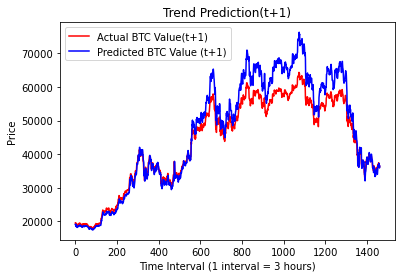

In [59]:
plt.plot(a1, color = 'red', label = 'Actual BTC Value(t+1)')
plt.plot(p1, color = 'blue', label = 'Predicted BTC Value (t+1)') #[1:38]
plt.title('Trend Prediction(t+1)')
plt.xlabel('Time Interval (1 interval = 3 hours)')
plt.ylabel('Price')
plt.legend()

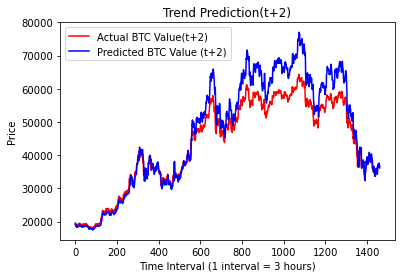

In [60]:
p2= dataplot['Predicted (t+2)']
a2= dataplot['Actual (t+2)']
plt.plot(a2, color = 'red', label = 'Actual BTC Value(t+2)')
plt.plot(p2, color = 'blue', label = 'Predicted BTC Value (t+2)') #[1:38]
plt.title('Trend Prediction(t+2)')
plt.xlabel('Time Interval (1 interval = 3 hours)')
plt.ylabel('Price')
plt.legend()



In [61]:
#Calculating RMSE and MAE
errorDF=concat([a1,p1], axis=1)
errorDF.dropna(inplace=True)
rmse = sqrt(mean_squared_error(errorDF.iloc[:,0], errorDF.iloc[:,1]))
mae = mean_absolute_error(errorDF.iloc[:,0], errorDF.iloc[:,1])
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

Test MAE: 3461.905
Test RMSE: 4657.348


In [62]:
errorDF=concat([a2,p2], axis=1)
errorDF.dropna(inplace=True)
rmse = sqrt(mean_squared_error(errorDF.iloc[:,0], errorDF.iloc[:,1]))
mae = mean_absolute_error(errorDF.iloc[:,0], errorDF.iloc[:,1])
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

Test MAE: 3848.533
Test RMSE: 5145.089
